In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks 

In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
torch.set_default_device(device)

In [3]:
# Creating Data

In [4]:
w = .7
b = .3

X = torch.arange(0, 1, .02).unsqueeze(dim=1)
y = w * X + b

In [5]:
X.shape

torch.Size([50, 1])

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [8]:
X_train.to('mps')

tensor([[0.5200],
        [0.0400],
        [0.8600],
        [0.4200],
        [0.4400],
        [0.5400],
        [0.4000],
        [0.1800],
        [0.1200],
        [0.7400],
        [0.7600],
        [0.9400],
        [0.6800],
        [0.2600],
        [0.1400],
        [0.8200],
        [0.6000],
        [0.1000],
        [0.6600],
        [0.5800],
        [0.2200],
        [0.7000],
        [0.3600],
        [0.3800],
        [0.1600],
        [0.0600],
        [0.2400],
        [0.5000],
        [0.0200],
        [0.8000],
        [0.4800],
        [0.6200],
        [0.9600],
        [0.3000],
        [0.7800],
        [0.0800],
        [0.2000],
        [0.9800],
        [0.5600],
        [0.2800]], device='mps:0')

## Visualization

In [9]:
import matplotlib.pyplot as plt

In [10]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """Plots training data, test data and compares predictions
    """
    plt.figure()
    
    # Plot training data in blue
    plt.scatter(train_data.cpu(), train_labels.cpu(), c='b', s=4, label='Training data')
    
    # Plot test data in gree
    plt.scatter(test_data.cpu(), test_labels.cpu(), c='g', s=4, label="Testing data")
    
    # Are there predictions?
    if predictions is not None:
        plt.scatter(test_data.cpu(), predictions.cpu(), c='r', s=4, label="Predictions")

    plt.legend(fontsize=14);

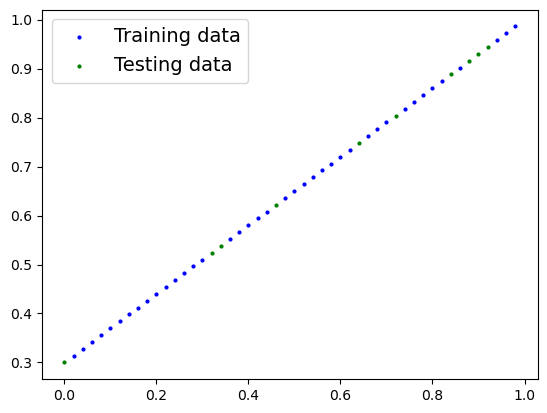

In [11]:
plot_predictions()

## Build Linear Regression Model Class

In [12]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.w = nn.Parameter(torch.randn(1, requires_grad=True))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True))


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w * x + self.b  # this is the linear regression formula        

In [13]:
model = LinearRegressionModel()
# print(i for i in model.parameters())
print(model.state_dict(), '\n\n')
list(model.parameters())

OrderedDict({'w': tensor([0.2356], device='mps:0'), 'b': tensor([0.9436], device='mps:0')}) 




[Parameter containing:
 tensor([0.2356], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([0.9436], device='mps:0', requires_grad=True)]

## Making Random Untrained Predictions with Model

In [14]:
with torch.inference_mode():
    y_preds = model(X_test)

y_preds

tensor([[1.1603],
        [1.1509],
        [1.0237],
        [1.1415],
        [1.1556],
        [1.0190],
        [1.0944],
        [0.9436],
        [1.1132],
        [1.0520]], device='mps:0')

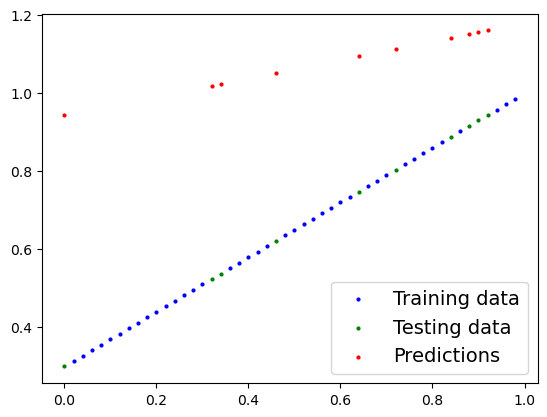

In [15]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

In [16]:
with torch.no_grad():
    y_preds = model(X_test)
y_preds

tensor([[1.1603],
        [1.1509],
        [1.0237],
        [1.1415],
        [1.1556],
        [1.0190],
        [1.0944],
        [0.9436],
        [1.1132],
        [1.0520]], device='mps:0')

In [17]:
y_preds = model(X_test)  # Don't go with this approach
y_preds

tensor([[1.1603],
        [1.1509],
        [1.0237],
        [1.1415],
        [1.1556],
        [1.0190],
        [1.0944],
        [0.9436],
        [1.1132],
        [1.0520]], device='mps:0', grad_fn=<AddBackward0>)

## Training the Model

### Define criterion and optimizer

In [18]:
# check parameters
list(model.parameters())

[Parameter containing:
 tensor([0.2356], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([0.9436], device='mps:0', requires_grad=True)]

In [19]:
model.state_dict()

OrderedDict([('w', tensor([0.2356], device='mps:0')),
             ('b', tensor([0.9436], device='mps:0'))])

In [20]:
X_test.device

device(type='mps', index=0)

In [21]:
# Setup a loss function
criterion = nn.L1Loss()

# Setup an optimizer (Stocastic Gradient Descent)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

### Building a training loop in PyTorch + testing Loop
0. Loop thru the data
1. Forward Pass (**forward-propagation**)
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (**back-propagation**)
5. Optimizer step (**gradient-descent**)

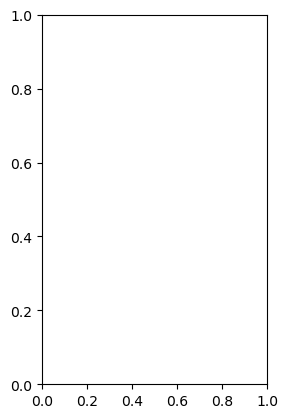

In [22]:
# An epoch: one loop through the data
epochs = 1000

train_loss_values = []
test_loss_values = []

# 0. Training loop
for epoch in range(epochs):
    # set the model to training loop, sets all parametres that require gradients to require_gradients=True
    model.train()


    # 1. Forward-propagation 
    y_pred = model(X_train)

    # 2. Calculate the loss
    loss = criterion(y_pred, y_train)
    plt.subplot(121)
    train_loss_values.append(loss)
        # After 20 Epochs we need to decrease the learning rate
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform Back-propagation on the loss with respect to the parameters of the model
    loss.backward()
    
    # 5. Step the optimizer (perform gradient-descent)
    optimizer.step()

    # Testing
    model.eval()  # turns off gradient tracking, set the model in evaluation modezq
    with torch.inference_mode():
        # Do the forward pass
        test_pred = model(X_test)
    
        # Calculate the loss
        test_loss = criterion(test_pred, y_test)
        
    test_loss_values.append(test_loss)


Text(0.5, 1.0, 'Training and Test Loss over epochs')

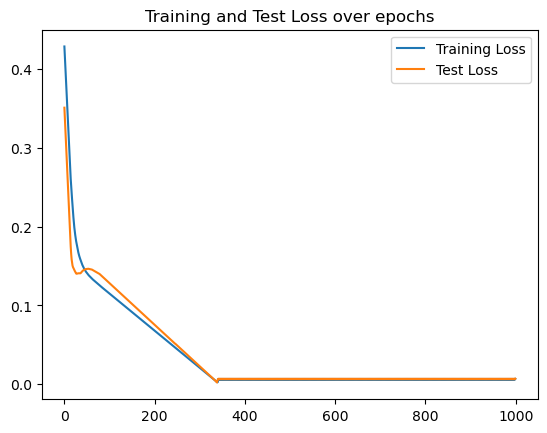

In [23]:
## Plot Training and Test loss curves

plt.plot(range(epoch+1), torch.tensor(train_loss_values).cpu())
plt.plot(range(epoch+1), torch.tensor(test_loss_values).cpu())
plt.legend(['Training Loss', 'Test Loss'])
plt.title("Training and Test Loss over epochs")

In [24]:
model.state_dict()

OrderedDict([('w', tensor([0.6921], device='mps:0')),
             ('b', tensor([0.2981], device='mps:0'))])

In [25]:
print(f'True w and b: {w} and {b}')

True w and b: 0.7 and 0.3


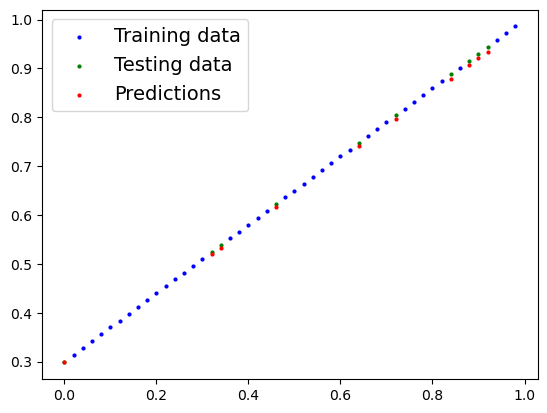

In [26]:
with torch.inference_mode():
    y_preds_new = model(X_test)
    plot_predictions(X_train, y_train, X_test, y_test, y_preds_new)

In [27]:
print(loss.item())

0.006525745149701834


## Saving the Model

In [28]:
torch.save(model.state_dict(), 'PyTorch_Linear_Regression_Model.pt')